In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

<AxesSubplot:>

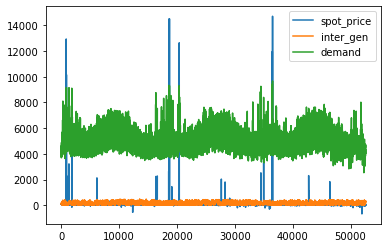

In [19]:
train = pd.read_csv("../../data/vic_train.csv")
valid = pd.read_csv("../../data/vic_cv.csv")
train_dates = pd.to_datetime(train['time'])
valid_dates = pd.to_datetime(valid['time'])

cols = list(train)[1:4]
df_train = train[cols].astype(float)
df_valid = valid[cols].astype(float)
df_train.plot.line()

<AxesSubplot:>

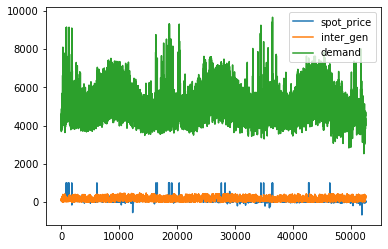

In [20]:
df_train.loc[df_train['spot_price'] > 1000, 'spot_price'] = 1000
df_train.plot.line()

In [21]:
# normalise dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df_train = scaler.fit_transform(df_train)

In [22]:
X_train = []
Y_train = []
n_future = 1
n_past = 18

In [23]:
for i in range(n_past, len(df_train) - n_future +1):
    X_train.append(df_train[i - n_past:i, 0:df_train.shape[1]])
    Y_train.append(df_train[i + n_future - 1:i + n_future, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('Y_train shape == {}.'.format(Y_train.shape))

X_train shape == (52590, 18, 3).
Y_train shape == (52590, 1).


# Model fitting

In [24]:
model = Sequential()
model.add(LSTM(64, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 18, 64)            17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


2021-09-27 23:15:50.591605: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-27 23:15:50.593285: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [25]:
# fit the model
model.fit(X_train, Y_train, epochs=20, batch_size=16, verbose=1)

Train on 52590 samples
Epoch 1/20
52590/52590 [==============================] - 176s 3ms/sample - loss: 0.0034
Epoch 2/20
52590/52590 [==============================] - 172s 3ms/sample - loss: 0.0011
Epoch 3/20
52590/52590 [==============================] - 173s 3ms/sample - loss: 8.4371e-04
Epoch 4/20
52590/52590 [==============================] - 173s 3ms/sample - loss: 7.7282e-04
Epoch 5/20
52590/52590 [==============================] - 173s 3ms/sample - loss: 7.3062e-04
Epoch 6/20
52590/52590 [==============================] - 175s 3ms/sample - loss: 6.9119e-04
Epoch 7/20
52590/52590 [==============================] - 176s 3ms/sample - loss: 6.7261e-04
Epoch 8/20
52590/52590 [==============================] - 175s 3ms/sample - loss: 6.3829e-04
Epoch 9/20
52590/52590 [==============================] - 174s 3ms/sample - loss: 5.9944e-04
Epoch 10/20
52590/52590 [==============================] - 175s 3ms/sample - loss: 5.1167e-04
Epoch 11/20
52590/52590 [=============================

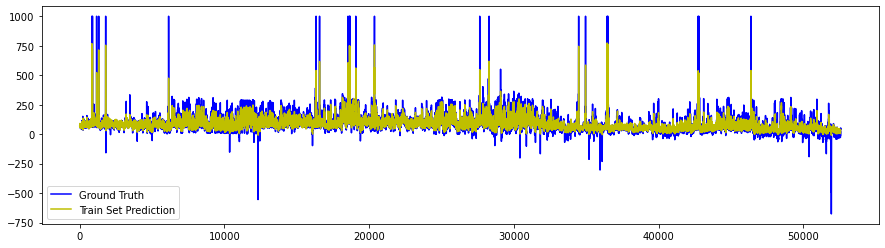

In [26]:
train_pred = model.predict(X_train)
train_pred = np.repeat(train_pred, df_train.shape[1], axis=-1)
train_pred = scaler.inverse_transform(train_pred)[:,0]
Y_train = np.repeat(Y_train, df_train.shape[1], axis=-1)
Y_train = scaler.inverse_transform(Y_train)[:,0]
plt.figure(figsize=(15, 4))
plt.plot(Y_train, label="Ground Truth", color='b')
plt.plot(train_pred, label="Train Set Prediction", color='y')
plt.legend()
plt.show()

# Prediction

In [27]:
valid_time = valid.time
actual = valid.spot_price
valid_copy = valid[['spot_price', 'inter_gen', 'demand']]
valid_copy = scaler.transform(valid_copy)

In [28]:
prediction = []
initial = train.iloc[-n_past:][['spot_price', 'inter_gen', 'demand']]
initial = scaler.transform(initial)
initial = initial.reshape(1, initial.shape[0], initial.shape[1])

for i in range(0, valid.shape[0]):
    pred = model.predict(initial)
    prediction.append(pred[0][0])
    new = np.array((valid_copy[i][0], valid_copy[i][1], valid_copy[i][2]))
    initial = np.delete(np.append(initial, new), [0, 1, 2]).reshape(1, n_past, 3)

# Evaluation

In [29]:
inter_gen = []
demand = []
for i in range(0, valid.shape[0]):
    inter_gen.append(valid_copy[i][1])
    demand.append(valid_copy[i][2])
valid_pred = np.array((prediction, inter_gen, demand)).transpose()
valid_pred = scaler.inverse_transform(valid_pred)
prediction = valid_pred.transpose()[0]

In [30]:
eval_df = pd.DataFrame({'Time':valid_time, 'Actual':actual, 'Prediction':prediction})
eval_df.set_axis(eval_df['Time'], inplace=True)
eval_df = eval_df.drop('Time', axis=1)

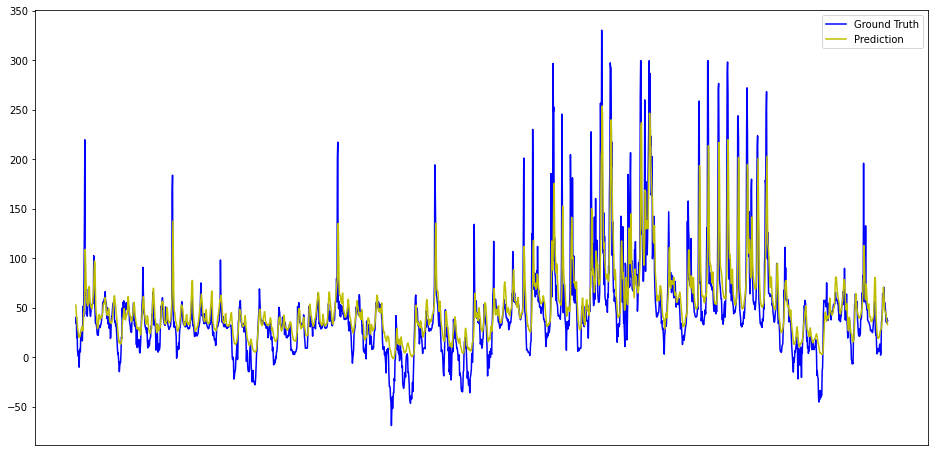

In [49]:
plt.figure(figsize=(16, 8))
plt.plot(eval_df[4000:6000]['Actual'], color='b', label='Ground Truth')
plt.plot(eval_df[4000:6000]['Prediction'], color='y', label='Prediction')
plt.xticks([])
plt.legend()
plt.show()

In [46]:
mse = mean_squared_error(eval_df.Actual, eval_df.Prediction)
print("LSTM Model RMSE:", math.sqrt(mse))

LSTM Model RMSE: 127.92586070735992
